In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


# Реализация метрики TPR@FPR

Черновую реализацию функций для прогона тестов можно найти в ноутбуке test-tprfpr.ipynb в корне проекта. Итоговую реализацию можно найти перейдя по импорту ниже:

In [3]:
from metrics.tprfpr import compute_ir

# Создание датасета

Код датасета можно найти перейдя по импорту ниже

In [4]:
from dataset.celeb import CelebDataset

Создадим три набра данных

In [5]:
train_dataset = CelebDataset(mode='train')
val_dataset = CelebDataset(mode='val')
test_dataset = CelebDataset(mode='test')

Посмотрим на семплы из набора

In [6]:
from utils.draw import draw_samples

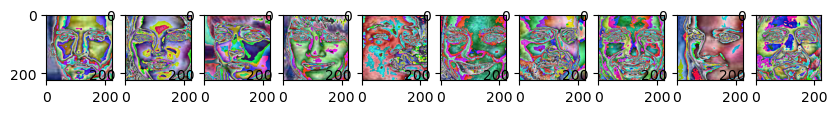

In [7]:
draw_samples(train_dataset)

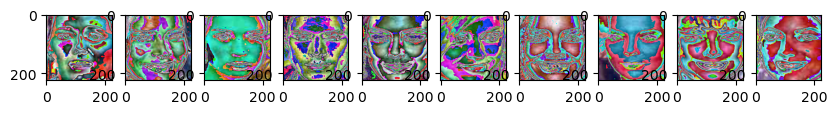

In [8]:
draw_samples(val_dataset)

## Weighted Random Sampler для учета дисбаланса классов

Классы в тренировочном датасете несбалансированы

Для учета дисбаланса можно воспользоваться WeightedRandomSampler

In [9]:
from collections  import Counter
from torch.utils.data.sampler import WeightedRandomSampler

train_targets = train_dataset.train_images['Target']
targets_count = Counter(i for i in train_targets)
weights = [1/targets_count.get(i) for i in train_targets]

weighted_random_sampler = WeightedRandomSampler(weights, num_samples=len(weights))

len(weights), weighted_random_sampler

(8318, <torch.utils.data.sampler.WeightedRandomSampler at 0x7fa4c7713fa0>)

# ResNet18 + Cross Entropy Loss

In [10]:
from models.resnet import ResNet18WithClassifier

In [11]:
num_classes = train_dataset.class_count()
model: ResNet18WithClassifier = ResNet18WithClassifier(num_classes=num_classes)

## Загрузим веса

Я обучил модель в GoogleColab на тех параметрах, что предствлены ниже в разделе  обучение модели.

In [12]:
model.load_state_dict(torch.load('./trained/resnet-18-epoch-11-75-acc-test.h5', map_location='cpu'))

<All keys matched successfully>

## Обучение модели

In [14]:
for param in model.resnet.parameters():
    param.requires_grad = True

In [ ]:
epochs = 100
lr = 1e-3
batch_size = 256

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    sampler=weighted_random_sampler
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size
)

In [ ]:
from train.train import train

In [ ]:
history = train(
    epochs=epochs,
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

## Вычисление TPR@FPR

In [13]:
thr = []
tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    x, y = compute_ir(model, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [14]:
test_thr, test_tpr

([0.5668753385543823,
  0.6307564973831177,
  0.6654475927352905,
  0.6938295364379883],
 [0.9735072345628694,
  0.8782012091569866,
  0.7689015691868759,
  0.6498879152231506])

## Посмотрим на TSNE для эмбеддингов

# ResNet18 + ArcFace